## Step 0. Library import

In [1]:
!pip install flopy

  Using cached flopy-3.6.0-py3-none-any.whl.metadata (7.7 kB)
Using cached flopy-3.6.0-py3-none-any.whl (1.4 MB)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.plot.styles import styles

## Step 1. Simulation parameters definition.

In [6]:
# Model units
length_units = "centimeters"
time_units = "seconds"

# Model parameters

## Discretization
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 122  # Number of columns
system_length = 12.0  # Length of system ($cm$)
delr = 0.1  # Column width ($cm$)
delc = 0.1  # Row width ($cm$)
top = 1.0  # Top of the model ($cm$)
botm = 0  # Layer bottom elevation ($cm$)

## Physical parameters
specific_discharge = 0.1  # Specific discharge ($cm s^{-1}$)
hydraulic_conductivity = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
porosity = 0.1  # Porosity of mobile domain (unitless)
source_concentration = 1.0  # Source concentration (unitless)
initial_concentration = 0.0  # Initial concentration (unitless)
total_time = 120.0  # Simulation time ($s$)

## Step 2. Path to MODFLOW6 and simulation name

In [3]:
ws = os.getcwd() # Ruta de donde estamos actualmente
mf6_exe = '/home/jovyan/GMMC/WMA/mf6/bin/mf6' # Ejecutable
name = 'flow' # Nombre de la simulación

print(' Ruta hacia el ejecutable de MODFLOW 6 : {} '.format(mf6_exe))
print(' Ruta actual : {}'.format(ws))
print(' Nombre de esta simulación: {}'.format(name))

 Ruta hacia el ejecutable de MODFLOW 6 : /home/jovyan/GMMC/WMA/mf6/bin/mf6 
 Ruta actual : /home/jovyan/GMMC/WMA/notebooks/test1D/flujo_1D
 Nombre de esta simulación: flow


## Step 3. Simulation object

In [4]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=mf6_exe)
print(sim)

sim_name = flow
sim_path = /home/jovyan/GMMC/WMA/notebooks/test1D/flujo_1D
exe_name = /home/jovyan/GMMC/WMA/mf6/bin/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = flow





## Step 4. Time discretization object

<center>
<img src="../figures/time_step.png" width=500px>
</center>
  
The length of a time step is calculated by multiplying the length of the previous time step by TSMULT. 
The length of the first time step, $\Delta t_1$, is related to PERLEN, NSTP, and TSMULT by the relation:
$$
\Delta t_1= \frac{\text{PERLEN}}{\text{NSTP}} \;\; \text{para} \;\; \text{TSMULT} = 1
$$

$$
\Delta t_1= \text{PERLEN} \frac{\text{TSMULT} - 1}{\text{TSMULT}^\text{nstp}-1} \;\; \text{para} \;\; \text{TSMULT} \neq 1
$$

The length of each successive time step is computed as

$$
\Delta t = \Delta t_{old} \text{TSMULT}
$$

where:
* `perlen` (double) is the length of a stress period.
* `nstp` (integer) is the number of time steps in a stress period.
* `tsmult` (double) is the multiplier for the length of successive time steps.
  
Véase: Hughes, J.D., Langevin, C.D., and Banta, E.R., 2017, *Documentation for the MODFLOW 6 framework: U.S. Geological Survey Techniques and Methods*, book 6, chap. A57, 40 p., https://doi.org/10.3133/tm6A57. **Timing Module, pp 10,12**.

In [7]:
tdis_ds = ((total_time, 1, 1.0),) # perlen, nstp, tsmult

In [8]:
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

package_name = flow.tdis
filename = flow.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = flow

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 1, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', '<i8'), ('tsmult', '<f8')]))



## Step 5. IMS object (solution calculation)

In [9]:
ims = flopy.mf6.ModflowIms(sim)
print(ims)

package_name = ims_-1
filename = flow.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = flow




## Step 6. GWF model object (flow)

In [10]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
print(gwf)

name = flow
model_type = gwf6
version = mf6
model_relative_path = .




## Step 7. Space discretization object

In [11]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              length_units=length_units,
                              nlay=nlay,
                              nrow=nrow,
                              ncol=ncol,
                              delr=delr,
                              delc=delc,
                              top=top,
                              botm=botm,
)
print(dis)

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(122)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0}





## Step 8. Initial conditions object

In [12]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=1.0)
print(ic)

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow

Block griddata
--------------------
strt
{constant 1.0}





## Step 9. Node Property Flow (NPF6) Package

In [13]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              save_specific_discharge=True,
                              save_saturation=True,
                              icelltype=0,
                              k=hydraulic_conductivity,
)
print(npf)

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow

Block options
--------------------
save_specific_discharge
{internal}
(True)

save_saturation
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.01}





## Step 10. Discharge object 

In [14]:
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]]) 
print(chd)

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow

Block period
--------------------
stress_period_data
{0: <flopy.mf6.data.mfdataplist.PandasListStorage object at 0x7f689dd0ef10>}




## Step 11. Wells object

In [15]:
wel_spd = {
    0: [ [(0, 0, 0),
          specific_discharge * delc * delr * top,
          source_concentration]
       ]
}

wel = flopy.mf6.ModflowGwfwel(gwf,
                              stress_period_data=wel_spd,
                              pname="WEL-1",
                              auxiliary=["CONCENTRATION"],
)

print(wel)

package_name = wel-1
filename = flow.wel
package_type = wel
model_or_simulation_package = model
model_name = flow

Block options
--------------------
auxiliary
{internal}
([('auxiliary', 'CONCENTRATION')])


Block period
--------------------
stress_period_data
{0: <flopy.mf6.data.mfdataplist.PandasListStorage object at 0x7f68a26acd50>}




## Step 12. Output object

In [19]:
head_filerecord = f"{name}.hds"
budget_filerecord = f"{name}.bud"
oc = flopy.mf6.ModflowGwfoc(gwf,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print(oc)

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow

Block options
--------------------
budget_filerecord
{internal}
([('flow.bud',)])

head_filerecord
{internal}
([('flow.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
None




## Step 13. Write Input files.

In [20]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package wel-1...
    writing package oc...


## Step 14. Run simulation

In [21]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../mf6/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 16:19:58 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government sh

(True, [])

## Step 15. Postprocessing

In [22]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(os.path.join(ws, head_filerecord)).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(os.path.join(ws, budget_filerecord),
                                  precision='double')
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [27]:
print(head.shape, '\n', head[0,0])

(1, 1, 122) 
 [13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1 12.  11.9 11.8
 11.7 11.6 11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7 10.6 10.5 10.4
 10.3 10.2 10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3  9.2  9.1  9.
  8.9  8.8  8.7  8.6  8.5  8.4  8.3  8.2  8.1  8.   7.9  7.8  7.7  7.6
  7.5  7.4  7.3  7.2  7.1  7.   6.9  6.8  6.7  6.6  6.5  6.4  6.3  6.2
  6.1  6.   5.9  5.8  5.7  5.6  5.5  5.4  5.3  5.2  5.1  5.   4.9  4.8
  4.7  4.6  4.5  4.4  4.3  4.2  4.1  4.   3.9  3.8  3.7  3.6  3.5  3.4
  3.3  3.2  3.1  3.   2.9  2.8  2.7  2.6  2.5  2.4  2.3  2.2  2.1  2.
  1.9  1.8  1.7  1.6  1.5  1.4  1.3  1.2  1.1  1. ]


In [28]:
print(qx.shape, '\n', qx)

(1, 1, 122) 
 [[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


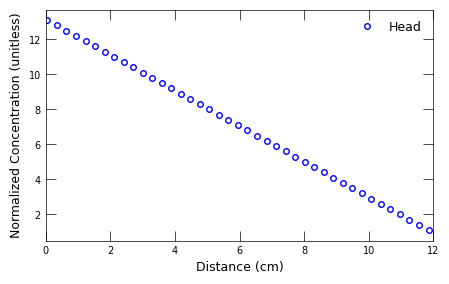

In [31]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'

    x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol)
    plt.figure(figsize=(5,3))
    plt.plot(x[::3], head[0, 0][::3], marker="o", ls ="none", mec="blue", mfc="none", markersize="4", label = 'Head')
    plt.xlim(0, system_length)
    plt.xlabel("Distance (cm)")
    plt.ylabel("Normalized Concentration (unitless)")
    plt.legend()
    plt.show()